### 【準備】VisonAPIのAPIキー（JSONファイル）を作成してダウンロードしておきます。

### VisionAPIをインストールします。

以下メッセージが表示されるので、**ランタイムを再起動**してください。

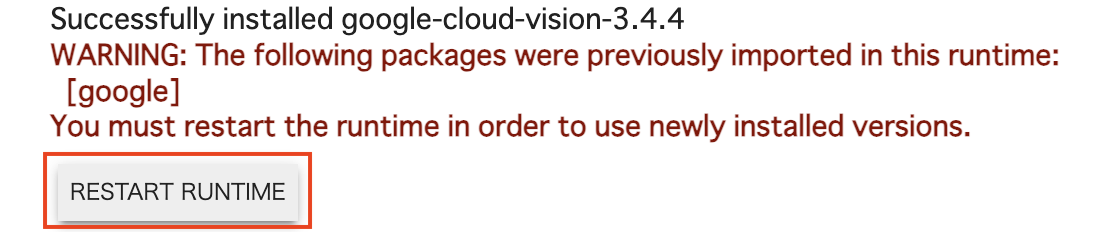





In [ ]:
!pip install --upgrade google-cloud-vision

### Githubより、必要なものを一式をダウンロードします。

In [ ]:
!git clone https://github.com/MamiTakata/aiocr-test.git
%cd aiocr-test

### APIキー（JSONファイル）をvisionapikey.jsonにコピーします。
上記でダウンロードした**/content/aiocr-test/visionapikey.json**に中身をコピーしてください。

### 以下プログラムを実行します。

In [ ]:
# パッケージをインポート
from google.oauth2 import service_account
from google.cloud import vision
import io
import cv2
import  imutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [ ]:
# 定数を定義
APIKEY = "visionapi/visionapikey.json"
IMAGE_PATH = "images/car.jpg"

In [ ]:
# Google認証（サービスアカウント認証）&初期化
credentials = service_account.Credentials.from_service_account_file(APIKEY)
scoped_credentials = credentials.with_scopes(['https://www.googleapis.com/auth/cloud-platform'])
client = vision.ImageAnnotatorClient(credentials=credentials)

In [ ]:
# 画像表示用
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
# 画像読み込みして表示
image = cv2.imread(IMAGE_PATH)
success, encoded_image = cv2.imencode('.jpg', image)
image_bytes = encoded_image.tobytes()

plt_imshow("Original Image", image)

In [ ]:
# 物体検出
image_vision_obj = vision.Image(content=image_bytes)
objects = client.object_localization(image=image_vision_obj).localized_object_annotations

# その中からナンバープレート検出してテキスト検出する
height, width = image.shape[0:2]
image_output = image.copy()
for obj in objects:
    if obj.name == "License plate":

      # ナンバープレート以外はマスクする
      contours = np.array([[(int(v.x * width), int(v.y * height)) for v in obj.bounding_poly.normalized_vertices]])
      mask = np.zeros(shape=(height, width), dtype=np.uint8)
      image_plate = cv2.drawContours(mask,[contours],0,255,-1)
      image_plate = cv2.bitwise_and(image,image,mask=mask)
      plt_imshow("License plate Image",image_plate)

      # ナンバープレート画像からテキスト検出
      success, encoded_image_plate = cv2.imencode('.jpg', image_plate)
      image_plate_bytes = encoded_image_plate.tobytes()
      image_vision_txt = vision.Image(content=image_plate_bytes)
      response = client.text_detection(image=image_vision_txt)
      texts = response.text_annotations

      if texts:
        print(texts[0].description)
      else:
        print("Could not read license plate.")
